In [4]:
# Setup Python path to import local modules
import sys
import os

# Add the parent directory (project root) to Python path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
print(f"Added {project_root} to Python path")
print(f"Current working directory: {os.getcwd()}")
print(f"Python path includes: {[p for p in sys.path if 'zipline-engine' in p]}")

Added /home/nakulbh/Desktop/Ankit/QuantMania/bactestingEngine/zipline-engine to Python path
Current working directory: /home/nakulbh/Desktop/Ankit/QuantMania/bactestingEngine/zipline-engine/examples
Python path includes: ['/home/nakulbh/Desktop/Ankit/QuantMania/bactestingEngine/zipline-engine', '/home/nakulbh/Desktop/Ankit/QuantMania/bactestingEngine/zipline-engine/.venv/lib/python3.10/site-packages']


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from engine.zipline_runner import TradingEngine
from engine.base_strategy import TradingConfig

# Import Zipline API functions
from zipline.api import (
    symbol, 
    schedule_function, 
    date_rules, 
    time_rules,
    order_target_percent,
    order_target_value,
    record,
    get_datetime
)

In [6]:
# Register the NSE bundle by importing the extension
# This loads our custom bundle registration
import os
os.environ['ZIPLINE_ROOT'] = '/home/nakulbh/Desktop/Ankit/QuantMania/bactestingEngine/zipline-engine/.zipline'

# Import the extension which registers our bundle
import sys
zipline_root = '/home/nakulbh/Desktop/Ankit/QuantMania/bactestingEngine/zipline-engine/.zipline'
if zipline_root not in sys.path:
    sys.path.insert(0, zipline_root)

# This will register the nse-equities-bundle
import extension

# Verify bundle is registered using the core module
from zipline.data.bundles.core import bundles
print("Available bundles:")
for bundle_name in bundles.keys():
    print(f"  - {bundle_name}")
    
# Check specifically for our bundle
if 'nse-equities-bundle' in bundles:
    print("\n✅ NSE bundle is registered and ready to use!")
else:
    print("\n❌ NSE bundle not found in registered bundles")
    print("Available bundles:", list(bundles.keys()))

INFO:extension:✅ nse-local-minute-bundle registered successfully
INFO:extension:✅ nse-daily-bundle registered successfully


Available bundles:
  - quandl
  - quantopian-quandl
  - csvdir
  - nse-local-minute-bundle
  - nse-daily-bundle

❌ NSE bundle not found in registered bundles
Available bundles: ['quandl', 'quantopian-quandl', 'csvdir', 'nse-local-minute-bundle', 'nse-daily-bundle']


In [10]:
class MomentumStrategy:
    """
    A momentum strategy that:
    1. Calculates 20-day returns for a universe of stocks
    2. Goes long the top 5 performers
    3. Goes short the bottom 5 performers
    4. Rebalances monthly
    """
    
    def __init__(self, config):
        self.config = config
        self.lookback_days = 20
        self.num_long = 5
        self.num_short = 5
        
    def initialize(self, context):
        """Initialize the strategy"""
        print("Initializing Momentum Strategy...")
        
        # Define our universe of stocks (using symbols we know exist in our bundle)
        context.universe = [
            symbol('BAJFINANCE'),  # Equity
            symbol('BANKNIFTY'),   # Index
            symbol('HDFCBANK'),    # Equity
            symbol('RELIANCE'),    # Equity
            symbol('SBIN')         # Equity
        ]

        # Use NIFTY 50 Index as benchmark
        context.benchmark = symbol('NIFTY50')

        # Initialize tracking variables
        context.long_positions = []
        context.short_positions = []
        context.rebalance_count = 0
        
        # Schedule rebalancing function to run on the first trading day of each month
        schedule_function(
            self.rebalance,
            date_rules.month_start(),
            time_rules.market_open()
        )
        
        print(f"Strategy initialized with {len(context.universe)} stocks")
        print("NIFTY50 included as benchmark symbol")
        
    def before_trading_start(self, context, data):
        """Called before trading starts each day"""
        # Record benchmark price for benchmark calculations
        if data.can_trade(context.benchmark):
            benchmark_price = data.current(context.benchmark, 'close')
            record(benchmark_price=benchmark_price)
        pass
        
    def rebalance(self, context, data):
        """Monthly rebalancing function"""
        context.rebalance_count += 1
        current_date = get_datetime()
        print(f"\n--- Rebalancing #{context.rebalance_count} on {current_date.date()} ---")
        
        # Calculate momentum scores
        momentum_scores = self.calculate_momentum(context, data)
        
        if momentum_scores is None or len(momentum_scores) < (self.num_long + self.num_short):
            print("Not enough data for rebalancing, skipping...")
            return
            
        # Sort by momentum (highest first)
        sorted_stocks = momentum_scores.sort_values(ascending=False)
        
        # Select long and short positions
        new_long_positions = sorted_stocks.head(self.num_long).index.tolist()
        new_short_positions = sorted_stocks.tail(self.num_short).index.tolist()
        
        print(f"Top {self.num_long} momentum stocks (LONG):")
        for i, stock in enumerate(new_long_positions, 1):
            momentum = sorted_stocks[stock]
            print(f"  {i}. {stock.symbol}: {momentum:.2%}")
            
        print(f"Bottom {self.num_short} momentum stocks (SHORT):")
        for i, stock in enumerate(new_short_positions, 1):
            momentum = sorted_stocks[stock]
            print(f"  {i}. {stock.symbol}: {momentum:.2%}")
        
        # Calculate position sizes
        long_weight = 0.8 / len(new_long_positions) if new_long_positions else 0
        short_weight = -0.2 / len(new_short_positions) if new_short_positions else 0
        
        # Close positions not in new portfolio
        all_new_positions = set(new_long_positions + new_short_positions)
        for stock in context.portfolio.positions:
            if stock not in all_new_positions:
                order_target_percent(stock, 0)
                print(f"  Closing position in {stock.symbol}")
        
        # Open long positions
        for stock in new_long_positions:
            if data.can_trade(stock):
                order_target_percent(stock, long_weight)
        
        # Open short positions  
        for stock in new_short_positions:
            if data.can_trade(stock):
                order_target_percent(stock, short_weight)
        
        # Update context
        context.long_positions = new_long_positions
        context.short_positions = new_short_positions
        
        # Record metrics
        record(
            num_long=len(new_long_positions),
            num_short=len(new_short_positions),
            leverage=context.account.leverage,
            portfolio_value=context.portfolio.portfolio_value
        )
        
    def calculate_momentum(self, context, data):
        """Calculate momentum scores for all stocks in universe"""
        momentum_scores = {}
        
        for stock in context.universe:
            try:
                # Get historical prices
                prices = data.history(stock, 'close', self.lookback_days + 1, '1d')
                
                if len(prices) >= self.lookback_days + 1:
                    # Calculate momentum as percentage return over lookback period
                    momentum = (prices.iloc[-1] / prices.iloc[0]) - 1
                    momentum_scores[stock] = momentum
                    
            except Exception as e:
                print(f"Error calculating momentum for {stock.symbol}: {e}")
                continue
        
        if momentum_scores:
            return pd.Series(momentum_scores)
        else:
            return None
            
    def handle_data(self, context, data):
        """Called every trading day"""
        # Record daily metrics
        record(
            portfolio_value=context.portfolio.portfolio_value,
            leverage=context.account.leverage,
            cash=context.portfolio.cash
        )

In [11]:
def run_backtest():
    # Configuration
    config = TradingConfig(
        start_date="2020-01-01",
        end_date="2022-12-31",
        capital_base=1000000,  # ₹10 lakhs
        commission_cost=0.001,
        output_dir='./results'
    )
    
    # Initialize engine and strategy
    engine = TradingEngine(config)
    strategy = MomentumStrategy(config)
    
    # Run backtest
    print("Running backtest...")
    results = engine.run_backtest(strategy)
    
    # Check what columns we have in results
    print("\nResults columns:", results['results'].columns.tolist())
    
    # Performance Analysis
    returns = results['returns']

    engine.create_tearsheet(returns)
    
    # Try to get benchmark returns (check if benchmark_price column exists)
    if 'benchmark_price' in results['results'].columns:
        benchmark = results['results']['benchmark_price'].pct_change().dropna()
        benchmark_available = True
    else:
        print("Note: benchmark_price not found in results")
        benchmark_available = False
    
    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    cumulative_returns = (1 + returns).cumprod()
    cumulative_returns.plot(label='Strategy', linewidth=2)
    
    if benchmark_available:
        cumulative_benchmark = (1 + benchmark).cumprod()
        cumulative_benchmark.plot(label='Benchmark', linewidth=2)
    
    plt.title('Cumulative Returns - Momentum Strategy')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print key metrics
    print("\n" + "="*50)
    print("STRATEGY PERFORMANCE SUMMARY")
    print("="*50)
    
    total_return = cumulative_returns.iloc[-1] - 1
    annual_return = (1 + returns.mean()) ** 252 - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    
    print(f"Total Return:     {total_return:.2%}")
    print(f"Annualized Return: {annual_return:.2%}")
    print(f"Volatility:       {volatility:.2%}")
    print(f"Sharpe Ratio:     {sharpe_ratio:.2f}")
    
    # Additional metrics
    max_drawdown = (cumulative_returns / cumulative_returns.expanding().max() - 1).min()
    winning_days = (returns > 0).sum()
    total_days = len(returns)
    win_rate = winning_days / total_days
    
    print(f"Max Drawdown:     {max_drawdown:.2%}")
    print(f"Win Rate:         {win_rate:.2%} ({winning_days}/{total_days} days)")
    
    if benchmark_available:
        benchmark_total = cumulative_benchmark.iloc[-1] - 1
        print(f"Benchmark Return: {benchmark_total:.2%}")
        print(f"Excess Return:    {total_return - benchmark_total:.2%}")
    
    print("="*50)
    
    return results, engine

INFO:engine.zipline_runner:Starting backtest...


Running backtest...
Initializing Momentum Strategy...
Strategy initialized with 5 stocks
NIFTY50 included as benchmark symbol

--- Rebalancing #1 on 2020-01-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #2 on 2020-02-03 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #3 on 2020-03-02 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #4 on 2020-04-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #5 on 2020-05-04 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #6 on 2020-06-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #7 on 2020-07-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #8 on 2020-08-03 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #9 on 2020-09-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #10 on 2020-10-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #11 on 2020-11-02 ---
Not 

INFO:zipline.finance.metrics.tracker:Simulated 744 trading days
 first open: 2020-01-01 03:45:00+00:00
 last close: 2022-12-30 10:00:00+00:00
INFO:engine.zipline_runner:Backtest completed successfully
INFO:engine.zipline_runner:Raw results saved to ./results/raw_results.pkl
INFO:engine.zipline_runner:Creating pyfolio tearsheet...
ERROR:engine.zipline_runner:Tearsheet creation failed: 'SeriesGroupBy' object has no attribute 'symbol'



--- Rebalancing #33 on 2022-09-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #34 on 2022-10-03 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #35 on 2022-11-01 ---
Not enough data for rebalancing, skipping...

--- Rebalancing #36 on 2022-12-01 ---
Not enough data for rebalancing, skipping...

Results columns: ['period_open', 'period_close', 'ending_value', 'starting_cash', 'ending_cash', 'returns', 'portfolio_value', 'longs_count', 'shorts_count', 'long_value', 'short_value', 'long_exposure', 'pnl', 'short_exposure', 'capital_used', 'orders', 'transactions', 'gross_leverage', 'positions', 'net_leverage', 'starting_exposure', 'ending_exposure', 'starting_value', 'max_leverage', 'excess_return', 'treasury_period_return', 'trading_days', 'period_label', 'algorithm_period_return', 'algo_volatility', 'benchmark_period_return', 'benchmark_volatility', 'alpha', 'beta', 'sharpe', 'sortino', 'max_drawdown']


INFO:engine.zipline_runner:Alternative tearsheet saved to ./results/figures/alternative_tearsheet.png


Note: benchmark_price not found in results


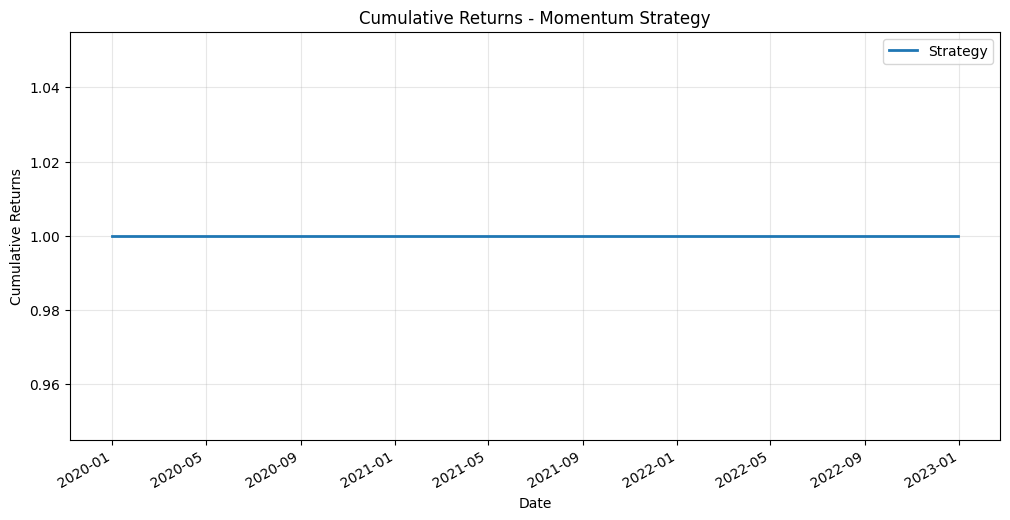


STRATEGY PERFORMANCE SUMMARY
Total Return:     0.00%
Annualized Return: 0.00%
Volatility:       0.00%
Sharpe Ratio:     nan
Max Drawdown:     0.00%
Win Rate:         0.00% (0/744 days)


In [12]:
results, engine = run_backtest()

In [33]:
returns = results['returns']


plyfolio_tear_sheet = engine.create_tearsheet(returns)
pyfolio_sheet = engine._create_alternative_tearsheet(returns)

INFO:engine.zipline_runner:Creating pyfolio tearsheet...
ERROR:engine.zipline_runner:Tearsheet creation failed: 'SeriesGroupBy' object has no attribute 'symbol'
INFO:engine.zipline_runner:Alternative tearsheet saved to ./results/figures/alternative_tearsheet.png
INFO:engine.zipline_runner:Alternative tearsheet saved to ./results/figures/alternative_tearsheet.png


In [14]:
class MomentumStrategy:
    """
    A momentum strategy that works with minute data:
    1. Calculates returns over a lookback period using minute bars
    2. Goes long the top performers
    3. Goes short the bottom performers
    4. Rebalances at specified intervals
    """
    
    def __init__(self):
        self.lookback_period = '20d'  # Can use '20d' or '4000m' (20 days * 200 minutes/day)
        self.num_long = 5
        self.num_short = 5
        self.rebalance_frequency = 'weekly'  # 'daily', 'weekly', 'monthly'
        
    def initialize(self, context):
        """Initialize the strategy for minute data"""
        print("Initializing Minute Momentum Strategy...")
        
        # Define our universe of stocks (using symbols from your bundle)
        context.universe = [
            symbol('BAJFINANCE'),  # sid: 0
            symbol('BANKNIFTY'),   # sid: 1
            symbol('HDFCBANK'),    # sid: 3
            symbol('RELIANCE'),    # sid: 6
            symbol('SBIN')        # sid: 7
        ]

        # Initialize tracking variables
        context.long_positions = []
        context.short_positions = []
        
        # Schedule rebalancing based on frequency
        if self.rebalance_frequency == 'daily':
            schedule_function(
                self.rebalance,
                date_rules.every_day(),
                time_rules.market_open(minutes=30)  # 9:45 AM
            )
        elif self.rebalance_frequency == 'weekly':
            schedule_function(
                self.rebalance,
                date_rules.week_start(),
                time_rules.market_open(minutes=30)
            )
        else:  # monthly
            schedule_function(
                self.rebalance,
                date_rules.month_start(),
                time_rules.market_open(minutes=30)
            )
        
        print(f"Strategy initialized with {len(context.universe)} stocks")
        print(f"Rebalancing frequency: {self.rebalance_frequency}")
        
    def before_trading_start(self, context, data):
        """Called before trading starts each day"""
        pass
        
    def rebalance(self, context, data):
        """Rebalancing function for minute data"""
        current_time = get_datetime()
        print(f"\n--- Rebalancing at {current_time} ---")
        
        # Calculate momentum scores using minute bars
        momentum_scores = self.calculate_momentum(context, data)
        
        if momentum_scores is None or len(momentum_scores) < (self.num_long + self.num_short):
            print("Not enough data for rebalancing, skipping...")
            return
            
        # Sort by momentum (highest first)
        sorted_stocks = momentum_scores.sort_values(ascending=False)
        
        # Select long and short positions
        new_long_positions = sorted_stocks.head(self.num_long).index.tolist()
        new_short_positions = sorted_stocks.tail(self.num_short).index.tolist()
        
        print(f"Top {self.num_long} momentum stocks (LONG):")
        for i, stock in enumerate(new_long_positions, 1):
            momentum = sorted_stocks[stock]
            print(f"  {i}. {stock.symbol}: {momentum:.2%}")
            
        print(f"Bottom {self.num_short} momentum stocks (SHORT):")
        for i, stock in enumerate(new_short_positions, 1):
            momentum = sorted_stocks[stock]
            print(f"  {i}. {stock.symbol}: {momentum:.2%}")
        
        # Calculate position sizes
        long_weight = 0.8 / len(new_long_positions) if new_long_positions else 0
        short_weight = -0.2 / len(new_short_positions) if new_short_positions else 0
        
        # Close positions not in new portfolio
        all_new_positions = set(new_long_positions + new_short_positions)
        for stock in context.portfolio.positions:
            if stock not in all_new_positions:
                order_target_percent(stock, 0)
                print(f"  Closing position in {stock.symbol}")
        
        # Open long positions
        for stock in new_long_positions:
            if data.can_trade(stock):
                order_target_percent(stock, long_weight)
        
        # Open short positions  
        for stock in new_short_positions:
            if data.can_trade(stock):
                order_target_percent(stock, short_weight)
        
        # Update context
        context.long_positions = new_long_positions
        context.short_positions = new_short_positions
        
        # Record metrics
        record(
            num_long=len(new_long_positions),
            num_short=len(new_short_positions),
            leverage=context.account.leverage,
            portfolio_value=context.portfolio.portfolio_value
        )
        
    def calculate_momentum(self, context, data):
        """Calculate momentum scores using minute bars"""
        momentum_scores = {}
        
        for stock in context.universe:
            try:
                # Get historical minute bars (use '1m' frequency)
                prices = data.history(
                    stock, 
                    'close', 
                    bar_count=self.lookback_period,
                    frequency='1m'
                )
                
                if len(prices) > 1:
                    # Calculate momentum as percentage return over lookback period
                    momentum = (prices.iloc[-1] / prices.iloc[0]) - 1
                    momentum_scores[stock] = momentum
                    
            except Exception as e:
                print(f"Error calculating momentum for {stock.symbol}: {e}")
                continue
        
        if momentum_scores:
            return pd.Series(momentum_scores)
        else:
            return None
            
    def handle_data(self, context, data):
        """Called every minute"""
        # Record minute metrics
        record(
            portfolio_value=context.portfolio.portfolio_value,
            leverage=context.account.leverage,
            cash=context.portfolio.cash
        )

def run_momentum_backtest():
    """Run backtest for the minute MomentumStrategy"""
    # Configuration for minute data backtest
    config = {
        'start_date': pd.Timestamp('2021-01-01', tz='utc'),
        'end_date': pd.Timestamp('2021-03-31', tz='utc'),
        'capital_base': 1000000,
        'data_frequency': 'minute',
        'bundle': 'nse-local-minute-bundle'
    }
    
    # Create and run the strategy
    strategy = MomentumStrategy()
    results = engine.run_algorithm(
        initialize=strategy.initialize,
        handle_data=strategy.handle_data,
        before_trading_start=strategy.before_trading_start,
        capital_base=config['capital_base'],
        data_frequency=config['data_frequency'],
        bundle=config['bundle'],
        start=config['start_date'],
        end=config['end_date']
    )
    
    return results

In [ ]:
result = run_momentum_backtest()